In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128
BATCH_SIZE = 8
LATENT_DIM = 64
EPOCHS = 100

class DataLoader:
    def __init__(self, blur_csv, real_csv, blur_dir, real_dir):
        self.blur_df = pd.read_csv(blur_csv)
        self.real_df = pd.read_csv(real_csv)
        self.blur_dir = blur_dir
        self.real_dir = real_dir
        
    def load_image(self, filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return tf.cast(img, tf.float32) / 255.0
    
    def create_dataset(self):
        blur_files = [os.path.join(self.blur_dir, fname) for fname in self.blur_df['Filename'].values]
        real_files = [os.path.join(self.real_dir, fname) for fname in self.real_df['Filename'].values]
        
        train_blur, temp_blur, train_real, temp_real = train_test_split(
            blur_files, real_files, test_size=0.3, random_state=42
        )
        val_blur, test_blur, val_real, test_real = train_test_split(
            temp_blur, temp_real, test_size=0.5, random_state=42
        )
        
        def create_tf_dataset(blur_files, real_files):
            blur_dataset = tf.data.Dataset.from_tensor_slices(blur_files).map(
                self.load_image, num_parallel_calls=tf.data.AUTOTUNE
            )
            real_dataset = tf.data.Dataset.from_tensor_slices(real_files).map(
                self.load_image, num_parallel_calls=tf.data.AUTOTUNE
            )
            return tf.data.Dataset.zip((blur_dataset, real_dataset))
        
        train_dataset = create_tf_dataset(train_blur, train_real).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        val_dataset = create_tf_dataset(val_blur, val_real).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_dataset = create_tf_dataset(test_blur, test_real).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        
        return train_dataset, val_dataset, test_dataset

def compute_reconstruction_loss(real, predicted):
    return tf.reduce_mean(tf.reduce_sum(tf.square(real - predicted), axis=[1, 2, 3]))

def compute_kl_loss(mean, logvar):
    return -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1))

In [32]:
class SimpleVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(SimpleVAE, self).__init__()
        self.latent_dim = latent_dim
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 64),
            tf.keras.layers.Reshape((8, 8, 64)),
            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid')
        ])

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, data):
        blur_batch, real_batch = data
        
        with tf.GradientTape() as tape:
            mean, logvar = self.encode(blur_batch)
            
            z = self.reparameterize(mean, logvar)
            
            reconstruction = self.decode(z)
            
            reconstruction_loss = compute_reconstruction_loss(real_batch, reconstruction)
            kl_loss = compute_kl_loss(mean, logvar)
            total_loss = reconstruction_loss + 0.001 * kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        blur_batch, real_batch = data
        
        mean, logvar = self.encode(blur_batch)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decode(z)
        
        reconstruction_loss = compute_reconstruction_loss(real_batch, reconstruction)
        kl_loss = compute_kl_loss(mean, logvar)
        total_loss = reconstruction_loss + 0.001 * kl_loss
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - kl_loss: 525.3785 - loss: 4181.5942 - reconstruction_loss: 4181.0679 - val_kl_loss: 2209.5776 - val_loss: 1799.0250 - val_reconstruction_loss: 1796.8158
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 2352.9907 - loss: 1654.4530 - reconstruction_loss: 1652.1001 - val_kl_loss: 2504.8767 - val_loss: 1316.7410 - val_reconstruction_loss: 1314.2362
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 2453.5457 - loss: 1279.5089 - reconstruction_loss: 1277.0557 - val_kl_loss: 2233.6907 - val_loss: 1139.3765 - val_reconstruction_loss: 1137.1422
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 2199.5950 - loss: 1121.5747 - reconstruction_loss: 1119.3750 - val_kl_loss: 2110.2996 - val_loss: 1037.3729 - val_reconstruction_loss: 1035.2626
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 2012.6748 - loss: 1021.8116 - reconstruction_loss: 1019.7990 - val_kl_loss: 1833.7000 - val_loss: 969.9026 - val_reconstruction_loss: 968.0691
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 1798.1569 - loss: 953.3824 - reconstruction_loss: 951.5847 - val_kl_loss: 1588.3136 - val_loss: 918.0869 - val_rec

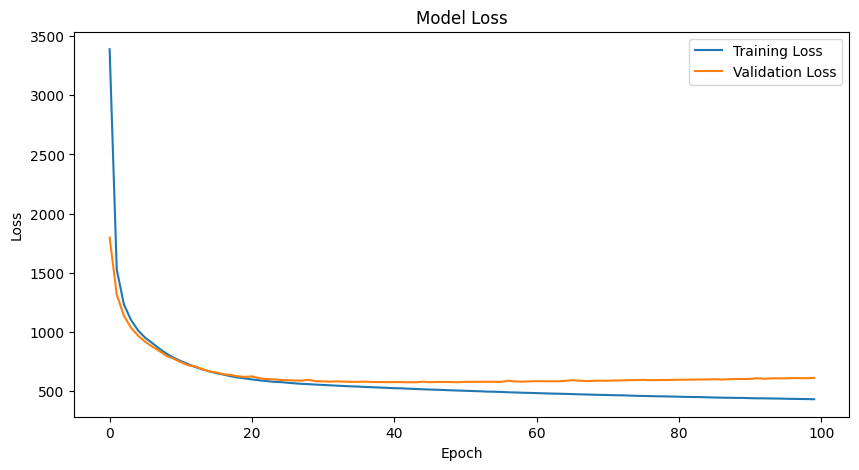

In [33]:
def train_vae():
    data_loader = DataLoader(
        blur_csv='/kaggle/input/dataset2/dataset/celeba_blurred_images.csv',
        real_csv='/kaggle/input/dataset2/dataset/celeba_images.csv',
        blur_dir='/kaggle/input/dataset2/dataset/blur',
        real_dir='/kaggle/input/dataset2/dataset/images'
    )
    
    train_dataset, val_dataset, test_dataset = data_loader.create_dataset()
    
    vae = SimpleVAE(LATENT_DIM)
    vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True
    )
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'vae_model_best.keras',
        monitor='loss',
        save_best_only=True
    )
    
    history = vae.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    return vae, history, test_dataset

def deblur_image(model, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)
    
    deblurred = model(img)
    deblurred = tf.squeeze(deblurred)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(img))
    plt.title('Blurred Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(deblurred)
    plt.title('Deblurred Image')
    plt.axis('off')
    plt.show()
    
    return deblurred

if __name__ == "__main__":
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    
    trained_model, history, test_dataset = train_vae()
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

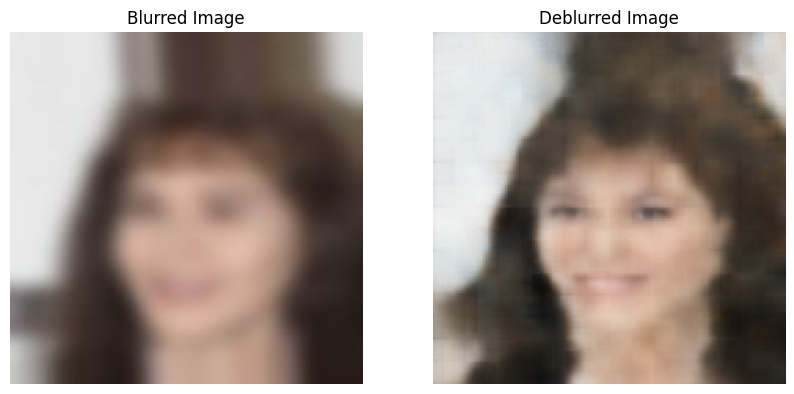

In [36]:
    test_image_path = '/kaggle/input/dataset2/dataset/blur/001060.jpg'
    deblurred_image = deblur_image(trained_model, test_image_path)